In [1]:
import fastprogress

In [2]:
from bayes_vi.utils.leapfrog_integrator import LeapfrogIntegrator
from bayes_vi.inference.vi.flow_bijectors import HamiltonianFlow, AffineFlow, make_energy_fn, make_scale_fn, make_shift_fn

In [155]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc("savefig", dpi=300)

plt.style.use('ggplot')

colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [4]:
import tensorflow as tf
import tensorflow_probability as tfp

# set tf logger to log level ERROR to avoid warnings
tf.get_logger().setLevel('ERROR')

tfd = tfp.distributions
tfb = tfp.bijectors
tfk = tf.keras

In [140]:
single_plot_fig_size = (7,4)
legend_loc = None
legend_framealpha = 0.8
subplot_adjust_bottom = 0.2

## Generate Test Data from Multivariate Gaussian Mixture Distribution

In [5]:
# generate parameters for the "true" underlying mixture model
num_datapoints = 10000

true_component_n = 4
dims = 2

fill_scale_tril = tfb.FillScaleTriL(diag_bijector=tfb.Softplus(), diag_shift=1.)

true_locs = tf.constant(np.random.choice(a=list(range(-20,20+1)), size=(true_component_n, dims)), dtype=tf.float32)

true_scales = tf.round(fill_scale_tril(
    tf.random.normal((true_component_n, dims*(dims+1)//2)))
)

selected_component = np.random.randint(0, true_component_n, 50)
true_component_weights = tf.constant(np.histogram(a=selected_component, bins=np.arange(true_component_n+1))[0]/selected_component.size, dtype=tf.float32)

In [6]:
true_component_weights, true_locs, true_scales

(<tf.Tensor: shape=(4,), dtype=float32, numpy=array([0.2 , 0.26, 0.3 , 0.24], dtype=float32)>,
 <tf.Tensor: shape=(4, 2), dtype=float32, numpy=
 array([[ 7., -3.],
        [11., -7.],
        [ 9., 10.],
        [-7.,  1.]], dtype=float32)>,
 <tf.Tensor: shape=(4, 2, 2), dtype=float32, numpy=
 array([[[ 1.,  0.],
         [-1.,  1.]],
 
        [[ 3.,  0.],
         [-0.,  2.]],
 
        [[ 1.,  0.],
         [-1.,  3.]],
 
        [[ 1.,  0.],
         [-0.,  3.]]], dtype=float32)>)

In [7]:
# create data generating mixture of gaussians
true_mvns = tfd.MultivariateNormalTriL(true_locs, true_scales)

true_mixture = tfd.MixtureSameFamily(
    mixture_distribution=tfd.Categorical(probs=true_component_weights),
    components_distribution=true_mvns
)

# generate data points by sampling from the distribution
y = true_mixture.sample(num_datapoints)
y

<tf.Tensor: shape=(10000, 2), dtype=float32, numpy=
array([[  7.7906475,  10.688838 ],
       [  4.445056 , -11.296453 ],
       [  7.674775 ,  -3.2574656],
       ...,
       [  8.976625 ,  -3.7825246],
       [  9.48768  ,  13.228449 ],
       [ -8.086709 ,   1.20125  ]], dtype=float32)>

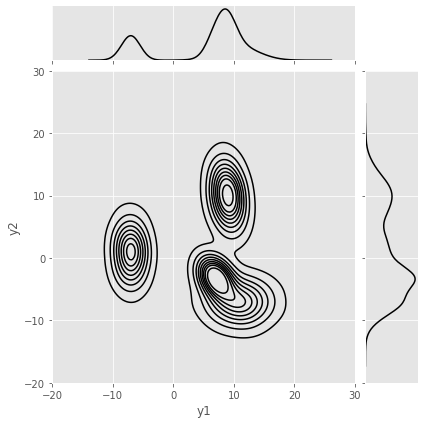

In [151]:
data = {'y1': y[:,0].numpy(), 'y2':y[:,1].numpy()}
ax = sns.jointplot(data=data, x='y1', y='y2', kind='kde', xlim=(-20, 30), ylim=(-20, 30), color='black')

In [153]:
ax.fig.savefig('./test-experiments/density-estimation-images/data_plot')

In [112]:
dataset = tf.data.Dataset.from_tensor_slices(y)

In [113]:
epochs = 50
batch_size = 50
sample_size = 10
optimizer = tf.optimizers.Adam(learning_rate=1e-3)

## Construct Hamiltonian Normalizing Flow

In [114]:
base_dist = tfd.MultivariateNormalDiag(loc=tf.zeros(shape=(dims*2,)), scale_diag=tf.ones(dims*2)*10)

loc_fn = make_shift_fn(dims, hidden_layers=[128,128])
scale_fn = make_scale_fn(dims, hidden_layers=[128,128])

encoder = lambda q: tfd.MultivariateNormalDiag(loc=loc_fn(q), scale_diag=scale_fn(q))

In [115]:
num_flows = 3
hnf = tfd.TransformedDistribution(
    base_dist, 
    bijector=tfb.Chain([
        tfb.Split(2, axis=-1),
        *[HamiltonianFlow(
            event_dims=dims,
            symplectic_integrator=LeapfrogIntegrator(), 
            step_sizes=tf.Variable(0.1), 
            num_integration_steps=2,
            hidden_layers=[128, 128]
        ) for _ in range(num_flows)]
        
    ])
)

## Construct Meanfield ADVI and Affine Flow

In [116]:
base_dist = tfd.MultivariateNormalDiag(loc=tf.zeros(shape=(dims,)), scale_diag=tf.ones(dims)*10)

affine_flow = tfd.TransformedDistribution(
    base_dist,
    bijector=AffineFlow(dims)
)

## Construct Continuous normalizing flow

In [117]:
def get_continuous_flow_bijector(unconstrained_event_dims):
    state_fn = tfk.Sequential()
    state_fn.add(tfk.layers.Dense(128, activation=tfk.activations.tanh))
    state_fn.add(tfk.layers.Dense(128, activation=tfk.activations.tanh))
    state_fn.add(tfk.layers.Dense(unconstrained_event_dims))
    state_fn.build((None, unconstrained_event_dims+1))
    state_time_derivative_fn = lambda t, state: state_fn(tf.concat([tf.fill((state.shape[0],1), t), state], axis=-1))
    return tfb.FFJORD(state_time_derivative_fn, 
                      ode_solve_fn=tfp.math.ode.DormandPrince(first_step_size=0.1).solve, 
                      trace_augmentation_fn=tfb.ffjord.trace_jacobian_hutchinson)

cnf = tfd.TransformedDistribution(
    base_dist,
    bijector=get_continuous_flow_bijector(dims)
)

## Train Hamiltonian Normalizing Flow

In [118]:
@tf.function(autograph=False)
def optimizer_step(q):
    
    with tf.GradientTape() as tape:
        cond_dist = encoder(q)
        p = cond_dist.sample(sample_size)
        loss = - tf.reduce_mean(hnf.log_prob([tf.stack([q]*sample_size, axis=0),p]) - cond_dist.log_prob(p))
    
    grads = tape.gradient(loss, tape.watched_variables())
    optimizer.apply_gradients(zip(grads, tape.watched_variables()))
    return loss

In [119]:
%%time
hnf_losses = []
i=0
ep = fastprogress.master_bar(range(epochs))
for _ in ep:
    data_generator = dataset.shuffle(batch_size*100).batch(batch_size=batch_size)
    batches = fastprogress.progress_bar(data_generator, parent=ep)
    for q in batches:
        i += 1 
        loss = optimizer_step(q)
        hnf_losses.append(loss.numpy())
    ep.main_bar.comment = "avg loss: {:.3f}".format(np.mean(hnf_losses[max(0, i - 100):i + 1]))


CPU times: user 11min 6s, sys: 2min 56s, total: 14min 2s
Wall time: 6min 58s


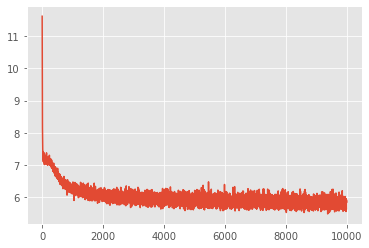

In [120]:
plt.plot(hnf_losses)

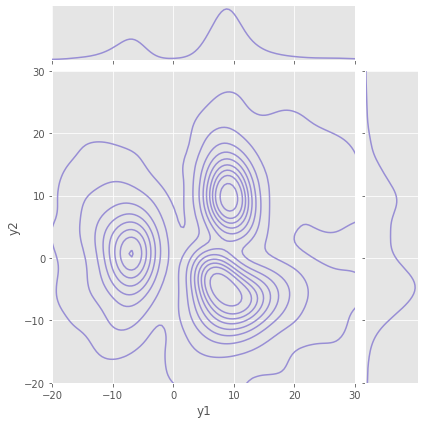

In [158]:
sample = hnf.sample(10000)[0]
data = {'y1': sample[:,0].numpy(), 'y2':sample[:,1].numpy()}
ax = sns.jointplot(data=data, x='y1', y='y2', kind='kde', xlim=(-20, 30), ylim=(-20, 30), color=colors[2])
ax.fig.savefig('./test-experiments/density-estimation-images/hnf_density_plot')

## Train Affine Flow

In [122]:
@tf.function(autograph=False)
def optimizer_step(q, dist):
    
    with tf.GradientTape() as tape:
        loss = - tf.reduce_mean(dist.log_prob(q))
    
    grads = tape.gradient(loss, tape.watched_variables())
    optimizer.apply_gradients(zip(grads, tape.watched_variables()))
    return loss

In [123]:
%%time
affine_losses = []
i=0
ep = fastprogress.master_bar(range(epochs))
for _ in ep:
    data_generator = dataset.shuffle(batch_size*100).batch(batch_size=batch_size)
    batches = fastprogress.progress_bar(data_generator, parent=ep)
    for q in batches:
        i += 1 
        loss = optimizer_step(q, affine_flow)
        affine_losses.append(loss.numpy())
    ep.main_bar.comment = "avg loss: {:.3f}".format(np.mean(affine_losses[max(0, i - 100):i + 1]))


CPU times: user 10.6 s, sys: 983 ms, total: 11.6 s
Wall time: 8.94 s


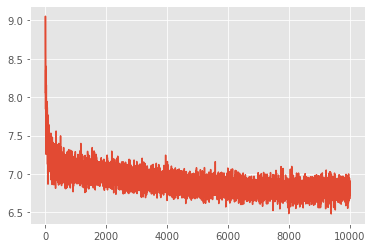

In [124]:
plt.plot(affine_losses)

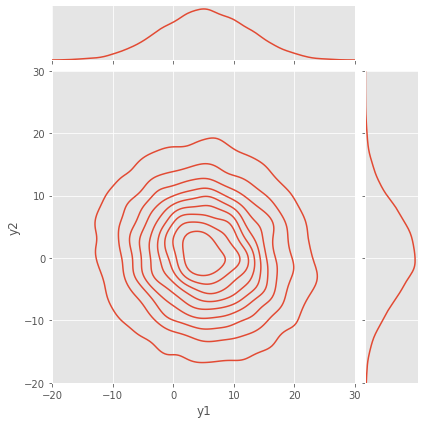

In [159]:
sample = affine_flow.sample(10000)
data = {'y1': sample[:,0].numpy(), 'y2':sample[:,1].numpy()}
ax = sns.jointplot(data=data, x='y1', y='y2', kind='kde', xlim=(-20, 30), ylim=(-20, 30), color=colors[0])
ax.fig.savefig('./test-experiments/density-estimation-images/affine_density_plot')

## Train Continuous Normalizing Flow

In [126]:
@tf.function(autograph=False)
def optimizer_step(q, dist):
    
    with tf.GradientTape() as tape:
        loss = - tf.reduce_mean(dist.log_prob(q))
    
    grads = tape.gradient(loss, tape.watched_variables())
    optimizer.apply_gradients(zip(grads, tape.watched_variables()))
    return loss

In [127]:
%%time
cnf_losses = []
i=0
ep = fastprogress.master_bar(range(epochs))
for _ in ep:
    data_generator = dataset.shuffle(batch_size*100).batch(batch_size=batch_size)
    batches = fastprogress.progress_bar(data_generator, parent=ep)
    for q in batches:
        i += 1 
        loss = optimizer_step(q, cnf)
        cnf_losses.append(loss.numpy())
    ep.main_bar.comment = "avg loss: {:.3f}".format(np.mean(cnf_losses[max(0, i - 100):i + 1]))


CPU times: user 17min 19s, sys: 1min 58s, total: 19min 17s
Wall time: 8min 41s


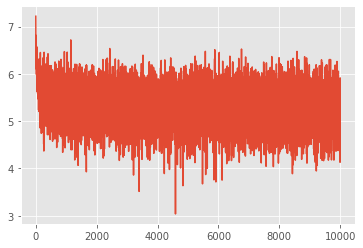

In [128]:
plt.plot(cnf_losses)

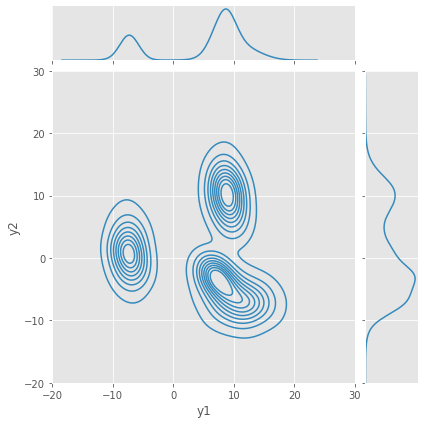

In [160]:
sample = cnf.sample(10000)
data = {'y1': sample[:,0].numpy(), 'y2':sample[:,1].numpy()}
ax = sns.jointplot(data=data, x='y1', y='y2', kind='kde', xlim=(-20, 30), ylim=(-20, 30), color=colors[1])
ax.fig.savefig('./test-experiments/density-estimation-images/cnf_density_plot')

In [165]:
loss_df = pd.DataFrame({'affine flow': affine_losses, 'cnf': cnf_losses, 'hnf(3)': hnf_losses})

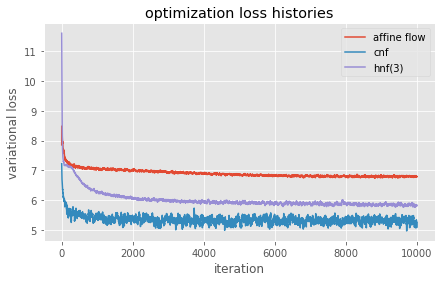

In [166]:
fig, ax = plt.subplots(1,1, figsize=single_plot_fig_size)
ax = loss_df.ewm(alpha=0.1).mean().plot(title='optimization loss histories', xlabel='iteration', ylabel='variational loss', ax=ax)

In [167]:
fig.savefig('./test-experiments/density-estimation-images/optimization_losses')

In [164]:
loss_df[-100:].mean()

affine_flow    6.792212
cnf            5.222511
hnf(3)         5.811356
dtype: float64